![alt text](metrics.png)

In [1]:
import torch
import torch.utils.data
from torch.utils.data import TensorDataset

import argparse
import time
import gc
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from tqdm.notebook import tqdm

# import wandb
import os

from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
torch.manual_seed(0)
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce GTX 1650')

In [3]:
from net import GNNStack
from utils_todynet import AverageMeter, accuracy, log_msg, get_default_train_val_test_loader, get_default_test_loader

In [4]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## aruguments

In [5]:
args = {
    'arch': 'dyGIN2d', #what other models I can put here?? dyGCN2d, dyGIN2d
    'dataset': 'Mortality', # "AtrialFibrillation" # 'Mortality', # 'MIMIC3'
    'num_layers': 2,  # the number of GNN layers  3
    'groups': 288,  # the number of time series groups (num_graphs)
    'pool_ratio': 0.0,  # the ratio of pooling for nodes initially 0.0 but since pooling destrots the nodes, and we want to have them i put it 0
    'kern_size': [3,3],  # list of time conv kernel size for each layer [9,5,3]
    'in_dim': 32,  # input dimensions of GNN stacks
    'hidden_dim': 32,  # hidden dimensions of GNN stacks
    'out_dim': 32,  # output dimensions of GNN stacks
    'workers': 4,  # number of data loading workers
    'epochs': 30,  # number of total epochs to run
    'batch_size': 4,  # mini-batch size, this is the total batch size of all GPUs
    'val_batch_size': 3,  # validation batch size
    'lr': 0.0001,  # initial learning rate
    'weight_decay': 1e-4,  # weight decay
    'evaluate': False,  # evaluate model on validation set
    'seed': 2,  # seed for initializing training
    'gpu': 0,  # GPU id to use
    'use_benchmark': True,  # use benchmark
    'tag': 'date',  # the tag for identifying the log and model files
    'loss':'bce'
}

In [6]:
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="mortality",
    
#     # track hyperparameters and run metadata
#     config=args
# )

In [7]:
# train_dataset = TensorDataset(data_train, label_train)
# val_dataset   = TensorDataset(data_val, label_val)

In [8]:
# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=args['batch_size'],shuffle=True, num_workers=args['workers'], pin_memory=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args['val_batch_size'], shuffle=False,num_workers=args['workers'],pin_memory=True)

In [9]:
# def main():
#     # args = parser.parse_args()
    
#     # args.kern_size = [ int(l) for l in args.kern_size.split(",") ]

#     # if args.seed is not None:
#     random.seed(args['seed'])
#     torch.manual_seed(args['seed'])

#     main_work(args)

In [10]:
def main_work(args):
    
    random.seed(args['seed'])
    torch.manual_seed(args['seed'])
    
    
    # init acc
    best_acc1 = 0
    best_roc  = 0
    best_pr   = 0
    
    if args['tag'] == 'date':
        local_date = time.strftime('%m.%d %H:%M', time.localtime(time.time()))
        args['tag'] = local_date

    # Use the 'tag' which now contains either the date or a custom tag along with the dataset name for the directory
    run_dir_name = f"{args['dataset']}_{args['tag']}"
    
    # Base directory for saving models
    base_model_save_dir = "saved_models"
    
    # Specific directory for this run
    specific_model_save_dir = os.path.join(base_model_save_dir, run_dir_name)
    os.makedirs(specific_model_save_dir, exist_ok=True)

    print(f"Models will be saved in: {specific_model_save_dir}")

    log_file = 'log/{}_gpu{}_{}_{}_exp.txt'.format(args['tag'], args['gpu'], args['arch'], args['dataset'])
    
    
    if args['gpu'] is not None:
        print("Use GPU: {} for training".format(args['gpu']))


    # dataset
    train_loader, val_loader, num_nodes, seq_length, num_classes = get_default_train_val_test_loader(args)
    
    print('features / nodes', num_nodes,'total time graphs',seq_length,'classes', num_classes)
    
    # training model from net.py
    model = GNNStack(gnn_model_type=args['arch'], num_layers=args['num_layers'], 
                     groups=args['groups'], pool_ratio=args['pool_ratio'], kern_size=args['kern_size'], 
                     in_dim=args['in_dim'], hidden_dim=args['hidden_dim'], out_dim=args['out_dim'], 
                     seq_len=seq_length, num_nodes=num_nodes, num_classes=num_classes)

    # print & log
    log_msg('epochs {}, lr {}, weight_decay {}'.format(args['epochs'], args['lr'], args['weight_decay']), log_file)
    
    log_msg(str(args), log_file)


    # determine whether GPU or not
    if not torch.cuda.is_available():
        print("Warning! Using CPU!!!")
    elif args['gpu'] is not None:
        torch.cuda.set_device(args['gpu'])

        # collect cache
        gc.collect()
        torch.cuda.empty_cache()

        model = model.cuda(args['gpu'])
        if args['use_benchmark']:
            cudnn.benchmark = True
        print('Using cudnn.benchmark.')
    else:
        print("Error! We only have one gpu!!!")


    # define loss function(criterion) and optimizer
    # class_weights = torch.tensor([0.087, 0.913], dtype=torch.float).cuda(args['gpu'])
    # class_weights = torch.tensor([0.913, 0.087], dtype=torch.float).cuda(args['gpu'])
    # class_weights = torch.tensor([1.0, 22.47], dtype=torch.float).cuda(args['gpu'])
    
    
    # criterion = nn.CrossEntropyLoss(weight=class_weights).cuda(args['gpu'])
    
    criterion = nn.CrossEntropyLoss().cuda(args['gpu'])
    
    # criterion = FocalLoss(gamma=0.1)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    # validation
    if args['evaluate']:
        validate(val_loader, model, criterion, args)
        return

    # train & valid
    print('****************************************************')
    print('Dataset: ', args['dataset'])

    dataset_time = AverageMeter('Time', ':6.3f')

    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []
    epoches = []
    
    ###### 4 more lists to have values
    roc_train = []
    pr_train  = []
    
    roc_val   = []
    pr_val    = []

    end = time.time()
    for epoch in tqdm(range(args['epochs'])):
        epoches += [epoch]

        # train for one epoch
        acc_train_per, loss_train_per, output_train_per, target_train_per = train(train_loader, model, criterion, optimizer, lr_scheduler, args)
        
        acc_train += [acc_train_per]
        loss_train += [loss_train_per]
        # calculate metric
        # print(len(target_train_per),len(output_train_per))
        auc_roc_value_train = roc_auc_score(target_train_per, output_train_per)
        auc_pr_value_train = average_precision_score(target_train_per, output_train_per)
        #new code
        roc_train += [auc_roc_value_train]
        pr_train  += [auc_pr_value_train]

        msg = f'TRAIN, epoch {epoch}, train_loss {loss_train_per}, train_acc {acc_train_per}, train_roc {auc_roc_value_train:.5f}, train_pr {auc_pr_value_train:.5f}'

        print(f'TRAIN, epoch {epoch}, train_loss {loss_train_per:.5f}, train_roc {auc_roc_value_train:.5f}, train_pr {auc_pr_value_train:.5f}')
        log_msg(msg, log_file)

        
        # evaluate on validation set
        acc_val_per, loss_val_per, output_val_per, target_val_per = validate(val_loader, model, criterion, args)

        acc_val  += [acc_val_per]
        loss_val += [loss_val_per]
        #calculate metric
        # calculate metric
        # print(len(target_val_per),len(output_val_per))
        auc_roc_value_val = roc_auc_score(target_val_per, output_val_per)
        auc_pr_value_val = average_precision_score(target_val_per, output_val_per)
        #new code

        msg = f'VAL, epoch {epoch}, val_loss {loss_val_per}, val_acc {acc_val_per}, val_roc {auc_roc_value_val:.5f}, val_pr {auc_pr_value_val:.5f}'
        
        print(f'VAL, epoch {epoch}, val_loss {loss_val_per:.5f}, val_roc {auc_roc_value_val:.5f}, val_pr {auc_pr_value_val:.5f}')
        log_msg(msg, log_file)

        
        
        # remember best acc
        best_acc1 = max(acc_val_per, best_acc1)
        
        best_roc = max(auc_roc_value_val, best_roc)
        
        best_pr  = max(auc_pr_value_val, best_pr)
        
#         wandb.log({"train_loss": loss_train_per, "train_roc": auc_roc_value_train, "train_pr": auc_pr_value_train, \
#                    "val_loss": loss_val_per, "val_roc": auc_roc_value_val, "val_pr": auc_pr_value_val, "best_val_roc": best_roc, "best_val_pr": best_pr})
#     wandb.finish()
        # Construct the filename with metrics
        acc_val_per_scalar = acc_val_per.item() if isinstance(acc_val_per, torch.Tensor) else acc_val_per
        auc_roc_value_val_scalar = auc_roc_value_val.item() if isinstance(auc_roc_value_val, torch.Tensor) else auc_roc_value_val
        auc_pr_value_val_scalar = auc_pr_value_val.item() if isinstance(auc_pr_value_val, torch.Tensor) else auc_pr_value_val
        
        # Now use these scalar values in the filename
        filename = f"model_epoch_{epoch}_acc_{acc_val_per_scalar:.3f}_roc_{auc_roc_value_val_scalar:.3f}_pr_{auc_pr_value_val_scalar:.3f}.pth"
        
        # Continue with the existing logic to save the model
        model_path = os.path.join(specific_model_save_dir, filename)
        torch.save(model.state_dict(), model_path)

    # measure elapsed time
    dataset_time.update(time.time() - end)

    # log & print the best_acc
    msg = f'\n\n * BEST_ACC: {best_acc1}\n * TIME: {dataset_time}\n'
    log_msg(msg, log_file)

    print(f' * best_acc1: {best_acc1}, best_roc: {best_roc}, best_pr: {best_pr}')
    print(f' * time: {dataset_time}')
    print('****************************************************')


    # collect cache
    gc.collect()
    torch.cuda.empty_cache()


def train(train_loader, model, criterion, optimizer, lr_scheduler, args):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc', ':6.2f')
    # met_roc = AverageMeter('ROC', ':6.2f')
    # met_pr = AverageMeter('PR', ':6.2f')
    
    output_list = []
    target_list = [] 

    # switch to train mode
    model.train()

    for count, (data, label) in enumerate(train_loader):

        # data in cuda
        data = data.cuda(args['gpu']).type(torch.float)
        label = label.cuda(args['gpu']).type(torch.long)

        # compute output
        output,feature_time_maps, adj_matrices, wadj_matrices = model(data)
    
        loss = criterion(output, label)

        # measure accuracy and record loss
        acc1 = accuracy(output, label, topk=(1, 1))
        
        output_np = torch.softmax(output, dim=1).detach().cpu().numpy()[:,1].tolist()
        
        target_np = label.detach().cpu().numpy().tolist()
        
        # print(output_np, target_np)
        
        losses.update(loss.item(), data.size(0))
        top1.update(acc1[0], data.size(0))
        
        # met_roc.update(roc, data.size(0))
        # met_pr.update(pr, data.size(0))
        output_list += output_np
        target_list += target_np

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step(top1.avg)

    return top1.avg, losses.avg, output_list, target_list


def validate(val_loader, model, criterion, args):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    # met_roc = AverageMeter('ROC', ':6.2f')
    # met_pr = AverageMeter('PR', ':6.2f')
    output_list = []
    target_list = [] 
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for count, (data, label) in enumerate(val_loader):
            if args['gpu'] is not None:
                data = data.cuda(args['gpu'], non_blocking=True).type(torch.float)
            if torch.cuda.is_available():
                label = label.cuda(args['gpu'], non_blocking=True).type(torch.long)

            # compute output
            output, feature_time_maps, adj_matrices, wadj_matrices = model(data)

            loss = criterion(output, label)
            
            output_np = torch.softmax(output, dim=1).detach().cpu().numpy()[:,1].tolist()
            target_np = label.detach().cpu().numpy().tolist()

            # measure accuracy and record loss
            acc1 = accuracy(output, label, topk=(1, 1))
            losses.update(loss.item(), data.size(0))
            top1.update(acc1[0], data.size(0))
            
            output_list += output_np
            target_list += target_np
            
            # met_roc.update(roc, data.size(0))
            # met_pr.update(pr, data.size(0))

    return top1.avg, losses.avg, output_list, target_list

In [11]:
def validate_extract(val_loader, model, criterion, args):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    # met_roc = AverageMeter('ROC', ':6.2f')
    # met_pr = AverageMeter('PR', ':6.2f')
    output_list = []
    target_list = [] 
    featuretime_list = []
    adj_list = []
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for count, (data, label) in enumerate(val_loader):
            if args['gpu'] is not None:
                data = data.cuda(args['gpu'], non_blocking=True).type(torch.float)
            if torch.cuda.is_available():
                label = label.cuda(args['gpu'], non_blocking=True).type(torch.long)

            # compute output
            output, feature_time_maps, adj_matrices, wadj_matrices = model(data)

            loss = criterion(output, label)
            
            output_np = torch.softmax(output, dim=1).detach().cpu().numpy()[:,1].tolist()
            target_np = label.detach().cpu().numpy().tolist()

            # measure accuracy and record loss
            acc1 = accuracy(output, label, topk=(1, 1))
            losses.update(loss.item(), data.size(0))
            top1.update(acc1[0], data.size(0))
            
            output_list += output_np
            target_list += target_np

            # featuretime_list += feature_time_maps
            # adj_list = adj_matrices
            
            
            # met_roc.update(roc, data.size(0))
            # met_pr.update(pr, data.size(0))

    return top1.avg, losses.avg, output_list, target_list, feature_time_maps, adj_matrices, wadj_matrices

In [12]:
def load_model(model_path, model_class, model_kwargs):
    """
    Load a model from a saved state dictionary.

    Parameters:
    - model_path: str, path to the saved model state dictionary.
    - model_class: class, the class of the model to instantiate.
    - model_kwargs: dict, keyword arguments for model class instantiation.

    Returns:
    - model: an instance of model_class with weights loaded from model_path.
    """
    # Instantiate the model with the provided keyword arguments
    model = model_class(**model_kwargs)
    
    # Load the state dictionary
    model.load_state_dict(torch.load(model_path))

    model = model.cuda(args['gpu'])
    # Set the model to evaluation mode
    model.eval()
    
    return model
# def predict(model, data_loader):
#     """
#     Predict the labels for the given data using the loaded model.

#     Parameters:
#     - model: The loaded model ready for prediction.
#     - data_loader: DataLoader for the dataset to predict on.

#     Returns:
#     - predictions: Predictions for the input data.
#     """
#     predictions = []
#     with torch.no_grad():  # No need to track gradients
#         for data in data_loader:
#             # Assuming your model expects data in a specific format, adjust accordingly
#             if torch.cuda.is_available():
#                 data = data.to('cuda')
#             output = model(data)
#             # Convert output to probabilities and then to the desired format
#             # For example, using softmax for classification
#             prob = torch.softmax(output, dim=1)
#             predicted_classes = prob.argmax(dim=1)
#             predictions.append(predicted_classes.cpu().numpy())  # Move to CPU and convert to numpy if needed
#     return predictions

In [13]:
main_work(args)

Models will be saved in: saved_models/Mortality_02.26 15:45
Use GPU: 0 for training
features / nodes 231 total time graphs 288 classes 2
Using cudnn.benchmark.
****************************************************
Dataset:  Mortality


  0%|          | 0/30 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.33 GiB. GPU 0 has a total capacty of 3.81 GiB of which 3.49 GiB is free. Including non-PyTorch memory, this process has 280.00 MiB memory in use. Of the allocated memory 162.88 MiB is allocated by PyTorch, and 39.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
#### model load

In [16]:
model_kwargs = {
    'gnn_model_type': args['arch'],
    'num_layers': args['num_layers'],
    'groups': args['groups'],
    'pool_ratio': args['pool_ratio'],
    'kern_size': args['kern_size'],
    'in_dim': args['in_dim'],
    'hidden_dim': args['hidden_dim'],
    'out_dim': args['out_dim'],
    'seq_len': 288, 
    'num_nodes': 231,  
    'num_classes': 2  
}

In [17]:
# Example usage
model_path = 'saved_models/Mortality_02.25 23:13/model_epoch_7_acc_93.859_roc_0.896_pr_0.594.pth'

In [18]:
model = load_model(model_path, GNNStack, model_kwargs)

In [19]:
# dataset
# train_loader, val_loader, num_nodes, seq_length, num_classes = get_default_train_val_test_loader(args)

test_loader, num_nodes, seq_length, num_classes = get_default_test_loader(args)

In [20]:
criterion = nn.CrossEntropyLoss().cuda(args['gpu'])

In [21]:
top1_avg_valid, losses_avg_valid, output_list, target_list,feature_time_maps, adj_matrices, wadj_matrices = validate_extract(test_loader, model, criterion, args)

In [22]:
auc_roc_value_val = roc_auc_score(target_list, output_list)
auc_pr_value_val = average_precision_score(target_list, output_list)

In [23]:
auc_roc_value_val, auc_pr_value_val

(0.8957830533427977, 0.5937036562267956)

### visualization

In [24]:
model

GNNStack(
  (g_constr): multi_shallow_embedding()
  (tconvs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (gconvs): ModuleList(
    (0-1): 2 x DenseGINConv2d(
      (mlp): Group_Linear(
        (group_mlp): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), groups=16, bias=False)
      )
    )
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (diffpool): ModuleList(
    (0-1): 2 x Dense_TimeDiffPool2d(
      (time_conv): Conv2d(231, 231, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (query): Linear(in_features=18, out_features=18, bias=True)
      (key): Linear(in_features=18, out_features=18, bias=True)
    )
  )
  (activation): SELU()
  (softmax): Softmax(dim=-1)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)

In [25]:
len(feature_time_maps), len(wadj_matrices)

(2, 2)

In [26]:
# feature_time_maps[0].shape

In [27]:
feature_time_maps_l1 = feature_time_maps[0]
feature_time_maps_l2 = feature_time_maps[1]

In [28]:
feature_time_maps_l1.shape, feature_time_maps_l2.shape

((2, 32, 231, 288), (2, 32, 231, 288))

In [29]:
# feature_time_maps_l1 == feature_time_maps_l2

In [30]:
adj_matrices_l1 = wadj_matrices[0]
adj_matrices_l2 = wadj_matrices[1]

In [31]:
adj_matrices_l1.shape, adj_matrices_l2.shape

((2, 16, 231, 231), (2, 16, 231, 231))

In [32]:
# import matplotlib.pyplot as plt
import numpy as np
# plt.imshow(adj_matrices_l1[2], cmap='RdBu_r') # Or use any other colormap 'gray', etc.
# plt.colorbar() # To add a color scale
# plt.show()

In [33]:
# np.max(adj_matrices_l2[0])

### load actual data

In [34]:
import torch

In [35]:
dtest = torch.load('Mortality/X_test.pt').numpy()
ltest = torch.load('Mortality/y_test.pt').numpy()

In [36]:
dtest.shape

(2231, 1, 231, 288)

In [37]:
# np.unique(ltest, return_counts=True) #### 186 positives

In [38]:
# np.where(ltest == 1.)

In [39]:
dtest.shape

(2231, 1, 231, 288)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [41]:
def scaless(array):
    row_means = array.mean(axis=1, keepdims=True)
    row_stds = array.std(axis=1, keepdims=True)
    # Avoid division by zero for rows with a standard deviation of 0
    # row_stds[row_stds == 0] = 1 

    # Perform row-wise standard scaling
    standard_scaled_array = (array - row_means) / row_stds
    return standard_scaled_array

In [42]:
# dtest_x = dtest[2230,...].squeeze()
dtest_x = dtest[2229,...].squeeze()

In [43]:
# dtest_x = scaless(dtest_x)

In [44]:
dtest_x.shape

(231, 288)

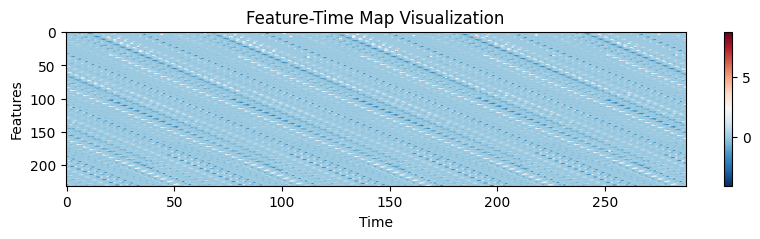

In [45]:
plt.figure(figsize=(10, 2))
plt.imshow(dtest_x, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.title('Feature-Time Map Visualization')
plt.xlabel('Time')
plt.ylabel('Features')
plt.show()

In [46]:
# feature_time_maps_l1[1]

In [47]:
mean_feature_time_maps_l1 = np.sum(feature_time_maps_l1, axis=1)
mean_feature_time_maps_l2 = np.sum(feature_time_maps_l2, axis=1)

# mean_feature_time_maps_l1 = np.mean(feature_time_maps_l1, axis=1)
# mean_feature_time_maps_l2 = np.mean(feature_time_maps_l2, axis=1)

In [48]:
mean_feature_time_maps_l1.shape, mean_feature_time_maps_l2.shape

((2, 231, 288), (2, 231, 288))

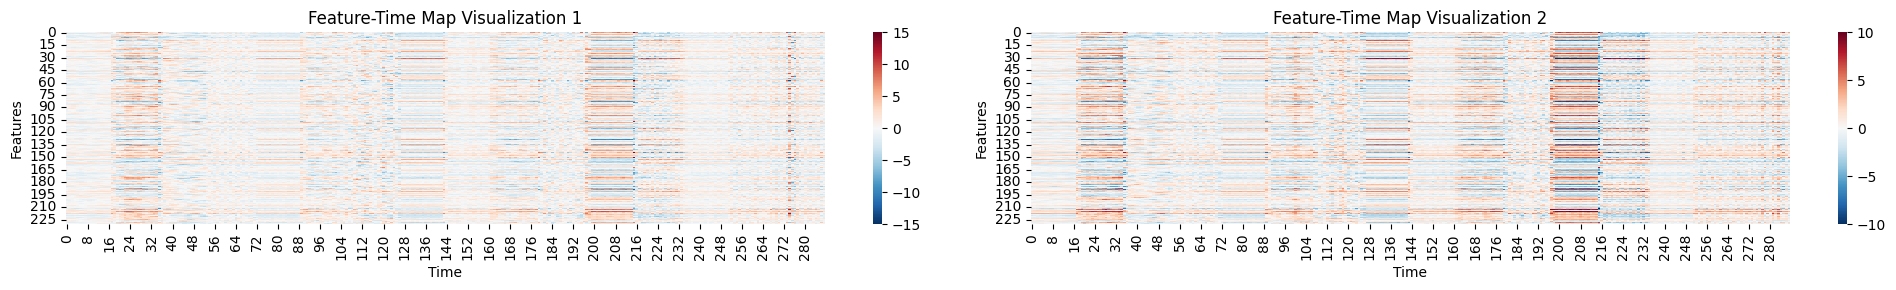

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'standard_scaled_ft_map' is your data
fig, ax = plt.subplots(1, 2, figsize=(20, 3))  # 1 row, 2 columns

# First subplot
sns.heatmap(mean_feature_time_maps_l1[0], cmap='RdBu_r', 
            vmin=-15, vmax=15, 
            ax=ax[0])
ax[0].set_title('Feature-Time Map Visualization 1')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Features')

# Second subplot - Repeating the same data for demonstration; modify as needed
sns.heatmap(mean_feature_time_maps_l1[1], cmap='RdBu_r', 
            vmin=-10, vmax=10, 
            ax=ax[1])
ax[1].set_title('Feature-Time Map Visualization 2')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Features')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [125]:
# diffl1 = mean_feature_time_maps_l1[0] - mean_feature_time_maps_l1[1]
# plt.figure(figsize=(10, 3))
# plt.imshow(diffl1, cmap='RdBu_r', vmin=-4, vmax=4)
# plt.colorbar()
# plt.title('Feature-Time Map Visualization')
# plt.xlabel('Time')
# plt.ylabel('Features')
# plt.show()

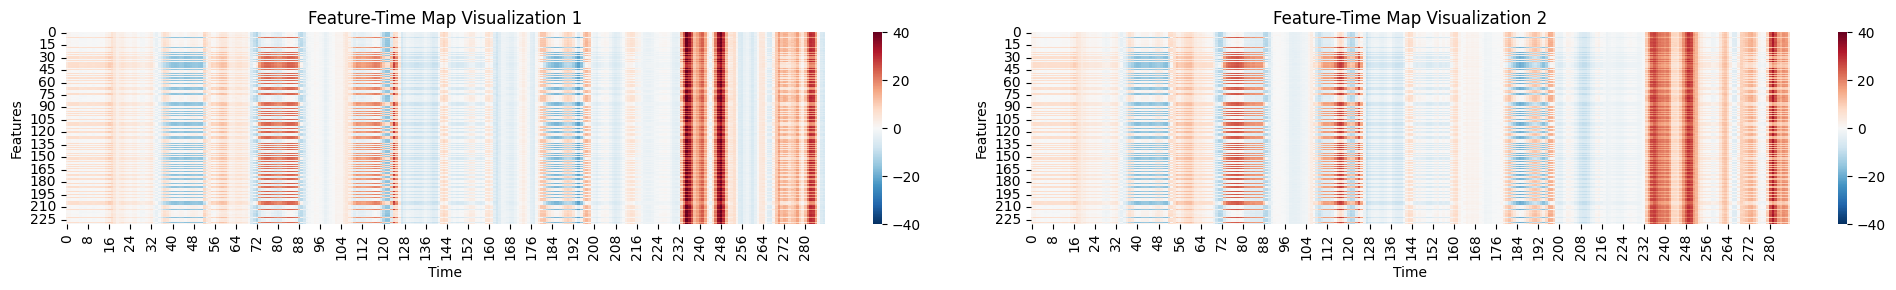

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'standard_scaled_ft_map' is your data
fig, ax = plt.subplots(1, 2, figsize=(20, 3))  # 1 row, 2 columns

# First subplot
sns.heatmap(mean_feature_time_maps_l2[0], cmap='RdBu_r', 
            vmin=-40, vmax=40, 
            ax=ax[0])
ax[0].set_title('Feature-Time Map Visualization 1')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Features')

# Second subplot - Repeating the same data for demonstration; modify as needed
sns.heatmap(mean_feature_time_maps_l2[1], cmap='RdBu_r', 
            vmin=-40, vmax=40, 
            ax=ax[1])
ax[1].set_title('Feature-Time Map Visualization 2')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Features')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [128]:
# diff = mean_feature_time_maps_l2[0] - mean_feature_time_maps_l2[1]
# plt.figure(figsize=(10, 3))
# plt.imshow(diff, aspect='auto', cmap='RdBu_r', vmin=-4, vmax=4)
# plt.colorbar()
# plt.title('Feature-Time Map Visualization')
# plt.xlabel('Time')
# plt.ylabel('Features')
# plt.show()

In [86]:
# # Assuming 'standard_scaled_ft_map' is a numpy array or pandas DataFrame with your data
# plt.figure(figsize=(20, 6))
# sns.clustermap(standard_scaled_ft_map, cmap='RdBu_r',col_cluster=False, method='complete', metric='cosine'
#                # vmin=-4, vmax=4
#               )

# plt.title('Feature-Time Map Visualization')
# plt.xlabel('Time')
# plt.ylabel('Features')
# plt.show()

In [129]:
# # Assuming you have a (208, 288) feature-time map named feature_time_map
# # For demonstration, creating a random map; replace this with your actual data
# ft_map = mean_feature_time_maps_l2[0,...]
# # ft_map = mean_feature_time_maps_l2[1,...]
# # normalized_ft_map = (ft_map - ft_map.min()) / (ft_map.max() - ft_map.min())
# # # Perform row-wise scaling
# # min_val = ft_map.min(axis=1, keepdims=True)
# # max_val = ft_map.max(axis=1, keepdims=True)

# # # Avoid division by zero for rows where all values are the same
# # denom = max_val - min_val
# # denom[denom == 0] = 1
# # normalized_ft_map = (ft_map - min_val) / denom

# # Calculate row-wise mean and standard deviation
# row_means = ft_map.mean(axis=1, keepdims=True)
# row_stds = ft_map.std(axis=1, keepdims=True)

# # Avoid division by zero for rows with a standard deviation of 0
# row_stds[row_stds == 0] = 1

# # Perform row-wise standard scaling
# standard_scaled_ft_map = (ft_map - row_means) / row_stds

# plt.figure(figsize=(10, 2))
# # plt.imshow(standard_scaled_ft_map, aspect='auto', cmap='RdBu', vmin=-6, vmax=6)
# plt.imshow(standard_scaled_ft_map, aspect='auto', cmap='RdBu_r', vmin=-4, vmax=4)
# # plt.imshow(ft_map, aspect='auto', cmap='RdBu', 
# #            # vmin=-4, vmax=4
# #           )
# plt.colorbar()
# plt.title('Feature-Time Map Visualization')
# plt.xlabel('Time')
# plt.ylabel('Features')
# plt.show()

In [55]:
np.max(adj_matrices_l2[1])

0.039304964

(231, 231)


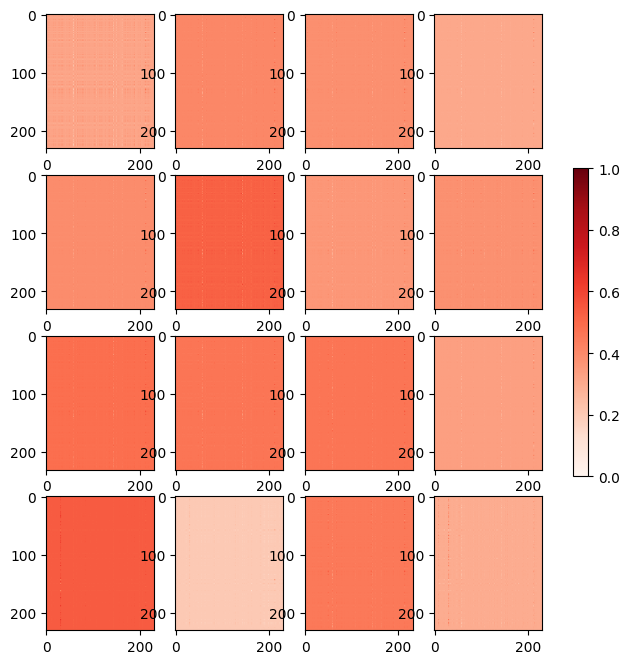

In [56]:
# Assuming adj_matrices_l1 is your list of adjacency matrices
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to your preference

for i, ax in enumerate(axes.flatten()):
    # Normalize the matrix to have values between 0 and 1
    adj_matrix = adj_matrices_l1[0][i]
    normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
    
    # Plot the normalized matrix
    # normalized_matrix = adj_matrices_l1[0][i]
    im = ax.imshow(normalized_matrix, aspect='auto', 
                   cmap='Reds', 
                   # cmap='PuBu', 
                   # vmin=0, vmax=1
                  )
    # ax.set_title(f'Adjacency Matrix {i+1}')
    # ax.set_xlabel('Features')
    # ax.set_ylabel('Features')

# Optional: Add a colorbar to the right of the subplots
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
print(normalized_matrix.shape)
# plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
plt.show()

(231, 231)


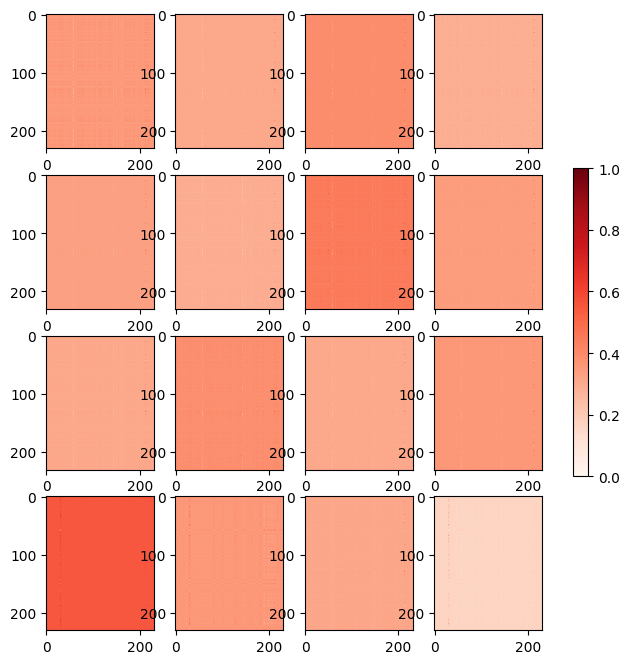

In [57]:
# Assuming adj_matrices_l1 is your list of adjacency matrices
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to your preference

for i, ax in enumerate(axes.flatten()):
    # Normalize the matrix to have values between 0 and 1
    adj_matrix = adj_matrices_l1[1][i]
    normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
    
    # Plot the normalized matrix
    im = ax.imshow(normalized_matrix, aspect='auto', 
                   cmap='Reds', 
                   # cmap='PuBu', 
                   # vmin=0, vmax=1
                  )
    # ax.set_title(f'Adjacency Matrix {i+1}')
    # ax.set_xlabel('Features')
    # ax.set_ylabel('Features')

# Optional: Add a colorbar to the right of the subplots
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
print(normalized_matrix.shape)
# plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
plt.show()

In [52]:
np.max(adj_matrices_l2), np.max(adj_matrices_l1)

(0.071155034, 0.035772033)

(231, 231)


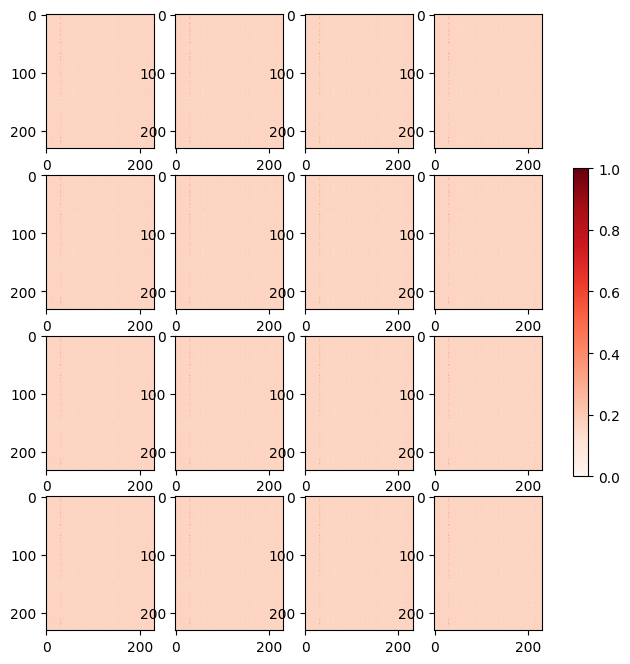

In [58]:
# Assuming adj_matrices_l1 is your list of adjacency matrices
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to your preference

for i, ax in enumerate(axes.flatten()):
    # Normalize the matrix to have values between 0 and 1
    adj_matrix = adj_matrices_l2[0][i]
    # normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
    # normalized_matrix = adj_matrix
    # binary_matrix = (normalized_matrix > 0.5).astype(int)
    # normalized_matrix = binary_matrix
    
    # Plot the normalized matrix
    im = ax.imshow(normalized_matrix, aspect='auto', 
                   cmap='Reds',
                   # cmap='PuBu', 
                   # vmin=0, vmax=1
                  )
    # ax.set_title(f'Adjacency Matrix {i+1}')
    # ax.set_xlabel('Features')
    # ax.set_ylabel('Features')

# Optional: Add a colorbar to the right of the subplots
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
print(normalized_matrix.shape)
# plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
plt.show()

(231, 231)


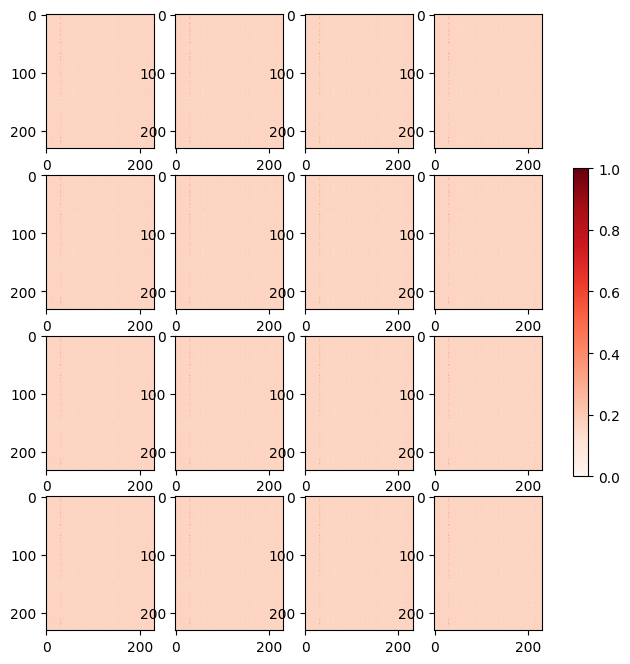

In [59]:
# Assuming adj_matrices_l1 is your list of adjacency matrices
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to your preference

for i, ax in enumerate(axes.flatten()):
    # Normalize the matrix to have values between 0 and 1
    adj_matrix = adj_matrices_l2[1][i]
    # normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
    # normalized_matrix = adj_matrix
    # binary_matrix = (normalized_matrix > 0.5).astype(int)
    # normalized_matrix = binary_matrix
    
    # Plot the normalized matrix
    im = ax.imshow(normalized_matrix, aspect='auto', 
                   cmap='Reds',
                   # cmap='PuBu', 
                   # vmin=0, vmax=1
                  )
    # ax.set_title(f'Adjacency Matrix {i+1}')
    # ax.set_xlabel('Features')
    # ax.set_ylabel('Features')

# Optional: Add a colorbar to the right of the subplots
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
print(normalized_matrix.shape)
# plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
plt.show()

In [60]:
import networkx as nx

In [61]:
adj_matrix = adj_matrices_l2[0]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())

In [57]:
# connected_nodes = np.sum(normalized_matrix, axis=0) + np.sum(normalized_matrix, axis=1) > 0

# # Filter out isolated nodes to create a new adjacency matrix
# new_adj_matrix = normalized_matrix[connected_nodes, :][:, connected_nodes]

In [58]:
# new_adj_matrix.shape

In [59]:
# # Plot only the large/highly connected components
# for component in large_components:
#     # Create a subgraph for this component
#     subgraph = G.subgraph(component)
    
#     # Draw the subgraph
#     plt.figure(figsize=(5, 5))
#     nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=100, edge_color='k')
#     plt.title("Highly Connected Component")
#     plt.show()

In [60]:
# adj_list = []

# for i in range(16):
#     adj_matrix = adj_matrices_l1[i]
#     normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())
#     adj_list.append(normalized_matrix)

In [61]:
# normalized_matrices = adj_list

In [62]:
# # Create a graph
# G_initial = nx.Graph()

# # Add all nodes explicitly
# G_initial.add_nodes_from(range(231))  # Add nodes with IDs from 0 to num_nodes-1

In [63]:
# pos = nx.spring_layout(G_initial)

In [64]:
# pos

In [65]:
# # Define a threshold for including edges
# threshold = 0

# # Calculate positions from the initial adjacency matrix
# G_initial = nx.Graph()
# for i in range(len(normalized_matrices)):
#     for j in range(i+1, len(normalized_matrices[0])):
#         if normalized_matrices[0][i, j] > threshold:
#             G_initial.add_edge(i, j)

# # Use the first graph to establish fixed node positions
# pos = nx.kamada_kawai_layout(G_initial)

In [66]:
# # Function to plot a graph from a normalized matrix
# def plot_graph_from_matrix(matrix, pos):
#     G = nx.Graph()
#     for i in range(len(matrix)):
#         for j in range(i+1, len(matrix)):
#             if matrix[i, j] > threshold:
#                 G.add_edge(i, j)
                
#     # Prepare graph attributes
#     d = dict(G.degree)
#     node_sizes = [d.get(k, 0) * 1 for k in range(len(matrix))]  # Adjust size calculation as needed
    
#     # Plot the graph
#     plt.figure(figsize=(10, 10))
#     nx.draw_networkx_nodes(G, pos, node_size=1, node_color='k', alpha=0.8)
#     nx.draw_networkx_edges(G, pos, edge_color='r', alpha=0.5)
#     plt.axis('off')
#     plt.show()

In [67]:
# # Plot each graph using the fixed positions
# for normalized_matrix in normalized_matrices:

#     pos = nx.spring_layout(G_initial)
    
#     plot_graph_from_matrix(normalized_matrix, pos)

In [68]:
# # Define a threshold for including edges
# threshold = 0.7  # Example threshold value

# # Create a graph from the adjacency matrix
# G = nx.Graph()



# # # Add edges to the graph based on the threshold
# # rows, cols = np.where(normalized_matrix >= threshold)
# # edges = zip(rows.tolist(), cols.tolist())
# # G.add_edges_from(edges)

# # Add weighted edges based on the adjacency matrix
# for i in range(len(normalized_matrix)):
#     for j in range(i+1, len(normalized_matrix)):
#         weight = normalized_matrix[i, j]
#         if weight > threshold:  # Check if weight is above the threshold
#             G.add_edge(i, j, weight=weight)
            
# pos = nx.kamada_kawai_layout(G)
# # Remove isolated nodes (optional)
# G.remove_nodes_from(list(nx.isolates(G)))

# nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1,2]]
# # Then, remove these nodes from the graph
# G.remove_nodes_from(nodes_with_some_neighbor)

# # nodes_with_two_neighbor = [node for node, degree in dict(G.degree()).items() if degree == 2]
# # # Then, remove these nodes from the graph
# # G.remove_nodes_from(nodes_with_two_neighbor)

# # Choose a layout
# pos = nx.kamada_kawai_layout(G)
# # pos = nx.spring_layout(G,iterations=5)
# d = dict(G.degree)
# # Plot the graph with enhanced visuals
# plt.figure(figsize=(10, 10))
# nx.draw_networkx_nodes(G, pos, node_size=[d[k]*1 for k in d], node_color='k', alpha=0.8)
# nx.draw_networkx_edges(G, pos, edge_color='r', alpha=0.5)
# # plt.title("Graph with Edges Above Threshold", size=15)
# plt.axis('off')  # Hide the axes
# plt.show()

In [62]:
import matplotlib.cm as cm

In [63]:
import pandas as pd

In [64]:
varname  = pd.read_csv('varname.csv')

In [65]:
var_names = varname['varname'].values.tolist()

In [66]:
# var_names

In [67]:
timeslot = 15

In [68]:
adj_matrix = adj_matrices_l1[0,timeslot,...]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())

In [69]:
# np.min(normalized_matrix)

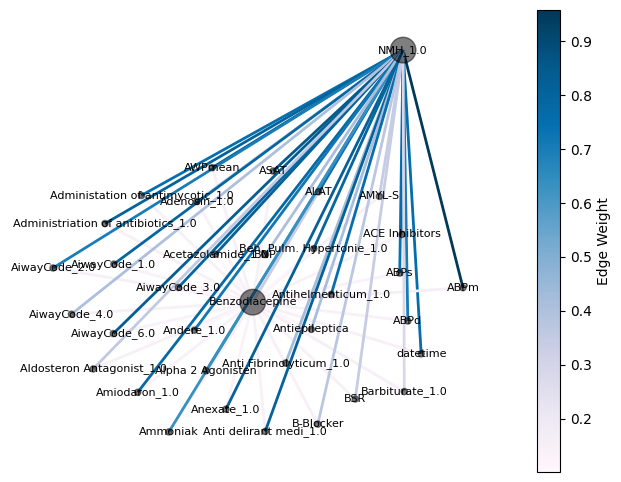

In [76]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import cm

# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.1#*np.max(normalized_matrix) # Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)

# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}

# Create a color map to map the normalized weights to colors
cmap = cm.PuBu  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]

# Plot the graph
plt.figure(figsize=(8, 6))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*10 for k in d], alpha=0.5)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight')

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=8)

plt.axis('off')
plt.show()

In [72]:
adj_matrix = adj_matrices_l2[0,timeslot,...]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())

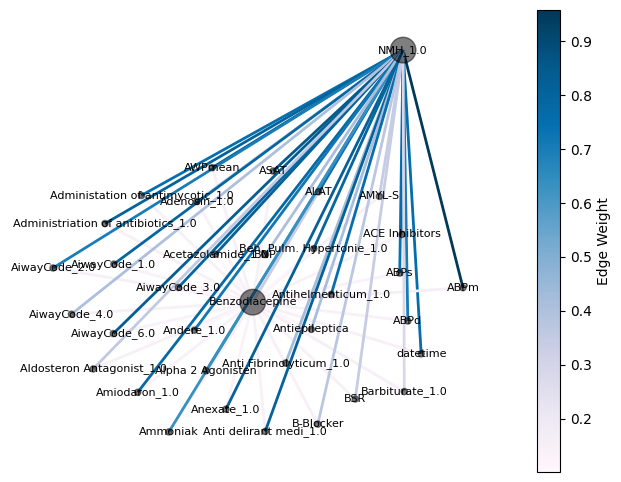

In [78]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import cm

# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.10#*np.max(normalized_matrix) # Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)

# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}

# Create a color map to map the normalized weights to colors
cmap = cm.PuBu  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]

# Plot the graph
plt.figure(figsize=(8, 6))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*10 for k in d], alpha=0.5)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight')

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=8)

plt.axis('off')
plt.show()

In [81]:
adj_matrix = adj_matrices_l2[0,0,...]
normalized_matrix = (adj_matrix - adj_matrix.min()) / (adj_matrix.max() - adj_matrix.min())

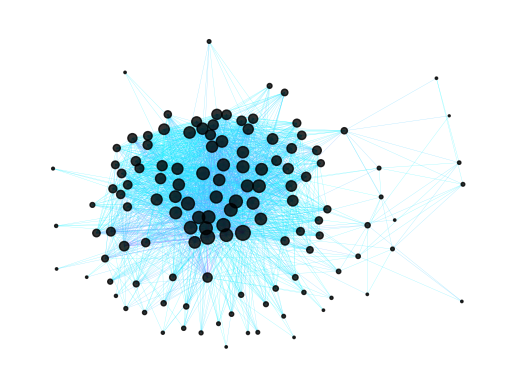

In [83]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np
# from matplotlib import cm

# # Example list of node names corresponding to each index in the adjacency matrix
# node_names_list = var_names  # and so on...

# # Assuming normalized_matrix is defined
# # normalized_matrix = ...

# # Define a threshold for including edges
# threshold = 0.8  # Example threshold value

# # Create a graph from the adjacency matrix
# G = nx.Graph()

# # Create a mapping of node IDs to names from your list
# node_names = var_names#{i: node_names_list[i] for i in range(len(normalized_matrix))}

# # Add weighted edges based on the adjacency matrix
# for i in range(len(normalized_matrix)):
#     for j in range(i+1, len(normalized_matrix)):
#         weight = normalized_matrix[i, j]
#         if weight > threshold:  # Check if weight is above the threshold
#             G.add_edge(i, j, weight=weight)

# # Remove isolated nodes (optional)
# G.remove_nodes_from(list(nx.isolates(G)))

# nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1,2]]
# # Then, remove these nodes from the graph
# G.remove_nodes_from(nodes_with_some_neighbor)

# # Adjust the node_names dictionary to only include nodes present in the graph after filtering
# filtered_node_names = {node: node_names[node] for node in G.nodes()}

# # Plot the graph
# pos = nx.kamada_kawai_layout(G)  # Calculate layout
# # pos = nx.kamada_kawai_layout(G)  # Calculate layout


# d = dict(G.degree)

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_color='gray', node_size=[d[k]*10 for k in d], alpha=0.8)

# # Draw edges
# nx.draw_networkx_edges(G, pos, edge_color='k', width=1,  alpha=0.8)

# # Draw node labels based on the filtered_node_names
# nx.draw_networkx_labels(G, pos, font_color='b', labels=filtered_node_names, font_size=8, verticalalignment='bottom',clip_on=False)

# plt.axis('off')  # Hide the axes
# plt.show()


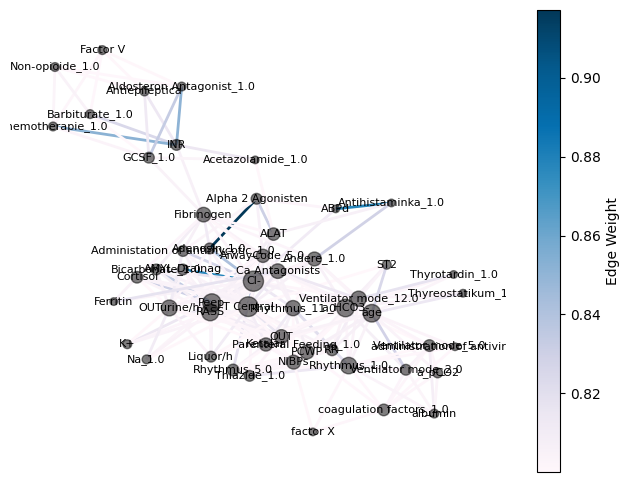

In [191]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import cm

# Assuming normalized_matrix is defined
# normalized_matrix = ...
node_names_list = var_names 
# Define a threshold for including edges
threshold = 0.8  # Example threshold value

# Create a graph from the adjacency matrix
G = nx.Graph()
node_names = var_names
# Add weighted edges based on the adjacency matrix
for i in range(len(normalized_matrix)):
    for j in range(i+1, len(normalized_matrix)):
        weight = normalized_matrix[i, j]
        if weight > threshold:  # Check if weight is above the threshold
            G.add_edge(i, j, weight=weight)

# Now extract the weights and normalize them
edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Remove isolated nodes (optional)
G.remove_nodes_from(list(nx.isolates(G)))

nodes_with_some_neighbor = [node for node, degree in dict(G.degree()).items() if degree in [1,2]]
# Then, remove these nodes from the graph
G.remove_nodes_from(nodes_with_some_neighbor)

# Adjust the node_names dictionary to only include nodes present in the graph after filtering
filtered_node_names = {node: node_names[node] for node in G.nodes()}



# Create a color map to map the normalized weights to colors
cmap = cm.PuBu  # You can choose a color map that you prefer

# Create a list of colors for each edge
edge_colors = [cmap(w) for w in weights_normalized]


# Plot the graph
plt.figure(figsize=(8, 6))  # Increase figure size for better clarity
# pos = nx.spring_layout(G)  # Use spring layout for node positions
pos = nx.kamada_kawai_layout(G)  # Use spring layout for node positions

d = dict(G.degree)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=[d[k]*10 for k in d], alpha=0.5)

# Draw edges with colors based on weights
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

# If you want to add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
sm.set_array([])
plt.colorbar(sm, label='Edge Weight')

# # Draw labels
# labels = {i: f"Node {i+1}" for i in range(len(normalized_matrix))}  # Replace with your actual labels
nx.draw_networkx_labels(G, pos, labels=filtered_node_names, font_size=8)

plt.axis('off')
plt.show()


In [111]:
node_names = [f'Node {i}' for i in range(231)]  # Replace with your actual node names
threshold = 0.6  # Define the threshold for including edges

# Create a graph
G = nx.Graph()

# Add nodes with labels
for i, name in enumerate(node_names):
    G.add_node(i, label=name)

# Add edges based on the threshold
for i in range(normalized_matrix.shape[0]):
    for j in range(i+1, normalized_matrix.shape[1]):  # Ensure i < j to add each edge only once
        if normalized_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=normalized_matrix[i, j])

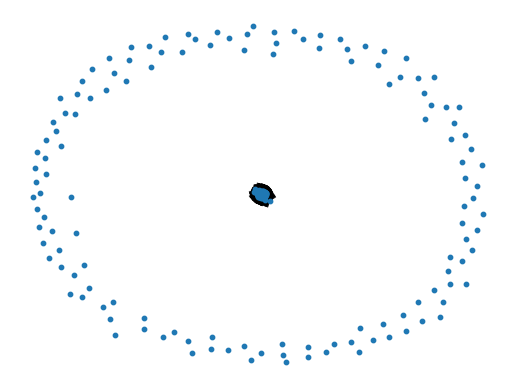

In [79]:
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=10)

# edges
edges = nx.draw_networkx_edges(G, pos,edge_color='k', width=10.0, alpha=0.5)

# labels
# labels = nx.get_node_attributes(G, 'label')
# nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.axis('off')  # Turn off the axis
plt.show()

In [80]:
#### weights of temporal layer

In [81]:
tconv_weights = model.tconvs[1].weight.data.cpu().numpy()

In [82]:
tconv_weights.shape

(32, 32, 1, 3)

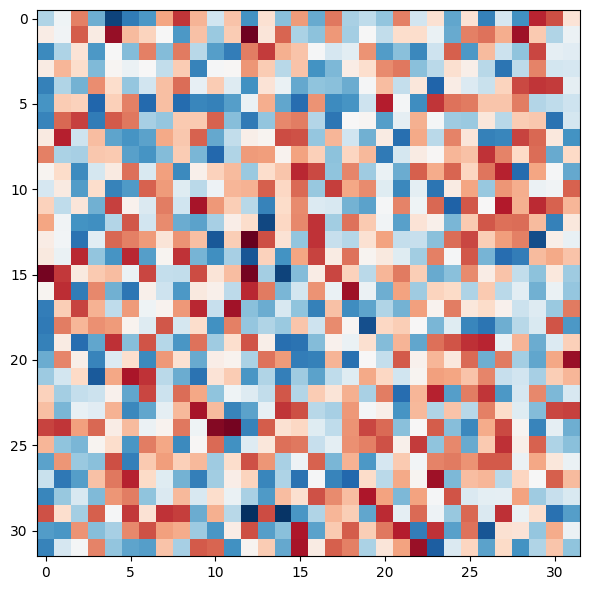

In [83]:
# Assuming adj_matrices_l1 is your list of adjacency matrices
fig, axes = plt.subplots(1, 1, figsize=(6, 6))  # Adjust figsize to your preference


im = axes.imshow(tconv_weights[:,:,:,2], aspect='auto', cmap='RdBu')

# Optional: Add a colorbar to the right of the subplots
# plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)

plt.tight_layout()  # Adjust layout to make room for titles, labels, etc.
plt.show()

In [84]:
temp_adj = adj_matrices_l2[-1]

In [64]:
temp_adj.shape

(208, 208)

In [65]:
glayer1 = model.gconvs[0]

In [66]:
glayer2 = model.gconvs[1]

In [67]:
glayer1

DenseGINConv2d(
  (mlp): Group_Linear(
    (group_mlp): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), groups=16, bias=False)
  )
)